In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from toolkit import filepath_to_csv, Orchids_filepath_to_csv

In [11]:
filepaths = [
    "round-3-island-data-bottle\prices_round_3_day_0.csv",
    "round-3-island-data-bottle\prices_round_3_day_1.csv",
    "round-3-island-data-bottle\prices_round_3_day_2.csv",
]
dfs = []
for filepath in filepaths:
    df = filepath_to_csv(filepath)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df['total_time'] = (df['day'])* 1000000 + df['timestamp']

In [12]:
choco = df[df['product'] == 'CHOCOLATE'].reset_index().drop(columns = 'index')
straw = df[df['product'] == 'STRAWBERRIES'].reset_index().drop(columns = 'index')
rose = df[df['product'] == 'ROSES'].reset_index().drop(columns = 'index')
gift = df[df['product'] == 'GIFT_BASKET'].reset_index().drop(columns = 'index')

pre_combine = choco.mid_price * 4 + straw.mid_price * 6 + rose.mid_price

trend = (choco.mid_price * 4 + straw.mid_price * 6 + rose.mid_price - gift.mid_price)
mean = trend.mean()
median = trend.median()
mean, median

(-379.4904833333333, -381.0)

In [108]:
np.mean(gift.mid_price)/np.mean(choco.mid_price)

8.933126797858847

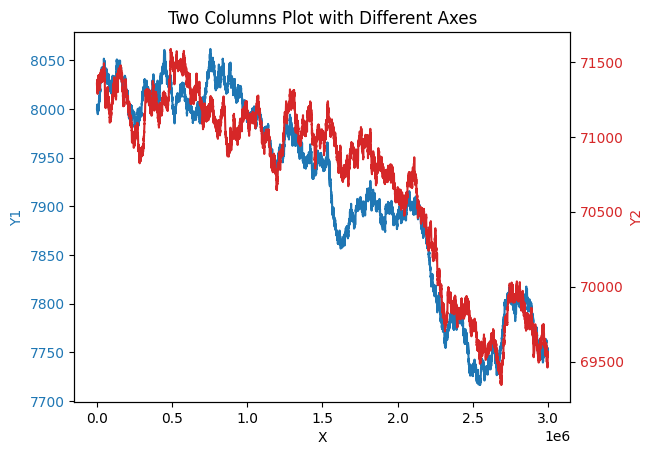

In [117]:
def graph_trends(df1, df2, col1, col2):
    fig, ax1 = plt.subplots()

    # Plotting the first data on the left axis
    color = 'tab:blue'
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y1', color=color)
    ax1.plot(df1['total_time'], df1[col1], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Creating a second y-axis and plotting the second data
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Y2', color=color)
    ax2.plot(df2['total_time'], df2[col2], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Two Columns Plot with Different Axes')
    plt.show()
graph_trends(choco, gift, 'mid_price', 'mid_price')

<Axes: >

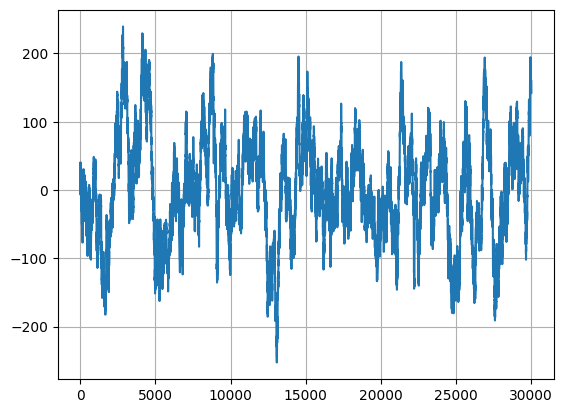

In [13]:
(trend - mean).plot(grid = True)

<Axes: >

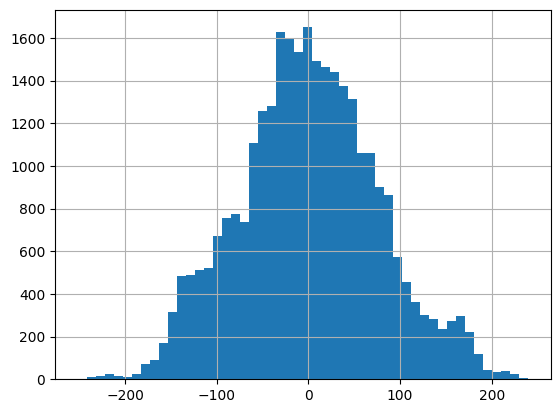

In [14]:
(trend + 380).hist(bins = 50)

<Axes: >

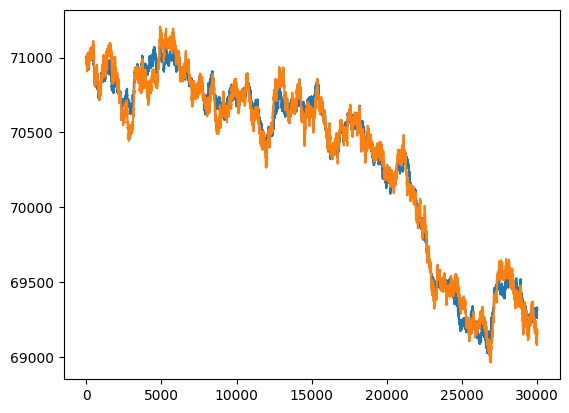

In [15]:
pre_combine.plot()
(gift.mid_price + mean).shift(2).plot()

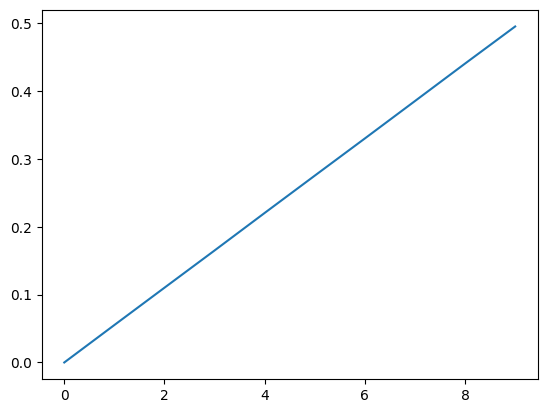

In [16]:
avg_diffs = []
for lag in range(10):
    diffs = []
    for i in range(len(pre_combine) - lag):
        diffs.append(pre_combine[i] - gift.mid_price[i + lag] - mean)
    avg_diff = np.mean(diffs)
    avg_diffs.append(avg_diff)
plt.plot([i for i in range(10)], avg_diffs)

Don't think there is any forward indicators here

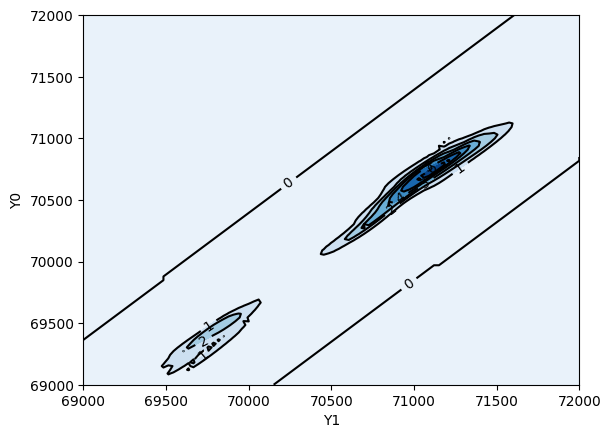

In [17]:
import numpy as np
import matplotlib.pyplot as pl
import scipy.stats as st

x = np.array(gift.mid_price)
y = np.array(pre_combine)
xmin, xmax = 69000, 72000
ymin, ymax = 69000, 72000

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = pl.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Y1')
ax.set_ylabel('Y0')

pl.show()

In [18]:
from statsmodels.distributions.copula.api import GaussianCopula

data = (pd.DataFrame({'col1': gift.mid_price + mean, 'col2': pre_combine})).values

# Calculate the correlation matrix between the two columns
corr_matrix = np.corrcoef(data.T)

# Fit Gaussian copula
gaussian_copula = GaussianCopula(corr=corr_matrix)

# Print the fitted correlation matrix
print("Fitted Correlation Matrix:")
print(gaussian_copula.corr)

# Calculate the Kendall's tau correlation matrix
kendalls_tau_corr = gaussian_copula.tau

# Print the Kendall's tau correlation matrix
print("Kendall's Tau Correlation Matrix:")
print(kendalls_tau_corr)


Fitted Correlation Matrix:
[[1.         0.99189699]
 [0.99189699 1.        ]]
Kendall's Tau Correlation Matrix:
<bound method EllipticalCopula.tau of <statsmodels.distributions.copula.elliptical.GaussianCopula object at 0x000001DB784C9D90>>


In [19]:
prices_df = pd.DataFrame({'col1': gift.mid_price + mean, 'col2': pre_combine})
prices_df['gap'] = prices_df.col1 - prices_df.col2
prices_df.head()

,col1,col2,gap
0,70975.509517,71000.0,-24.490483
1,70970.009517,71003.0,-32.990483
2,70967.509517,71001.5,-33.990483
3,70971.009517,71007.0,-35.990483
4,70962.009517,71002.5,-40.490483


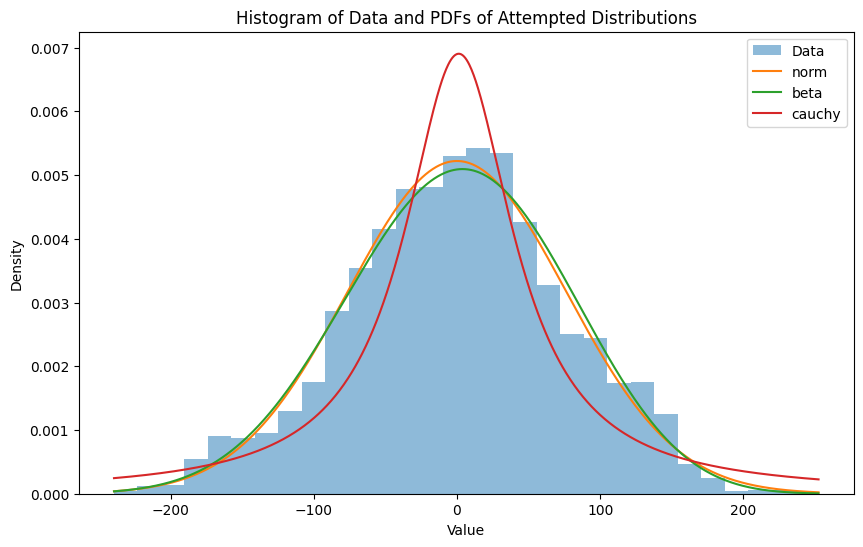

Distribution: norm, Params: (5.758677919705709e-12, 76.42310842343251), KS Statistic: 0.011547329884618814, KS p-value: 0.0006653623354769349
Distribution: beta, Params: (16.41433438508734, 12.798375121527167, -475.7889575554446, 846.7624267268641), KS Statistic: 0.016945316076345973, KS p-value: 6.507360669152948e-08
Distribution: cauchy, Params: (1.2520209081838702, 46.10920442809238), KS Statistic: 0.07958074082362876, KS p-value: 1.0482310116370915e-165


In [20]:
distributions = ['norm', 'beta', 'cauchy']

# Fit distributions and calculate goodness-of-fit measures
results = {}

plt.figure(figsize=(10, 6))
plt.hist(prices_df['gap'], bins=30, density=True, alpha=0.5, label='Data')

for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(prices_df['gap'])
    ks_statistic, ks_p_value = stats.kstest(prices_df['gap'], dist_name, args=params)
    results[dist_name] = {'params': params, 'ks_statistic': ks_statistic, 'ks_p_value': ks_p_value}
    
    x = np.linspace(prices_df['gap'].min(), prices_df['gap'].max(), 1000)
    plt.plot(x, dist.pdf(x, *params), label=dist_name)

plt.legend()
plt.title('Histogram of Data and PDFs of Attempted Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# Print results
for dist_name, dist_result in results.items():
    print(f"Distribution: {dist_name}, Params: {dist_result['params']}, KS Statistic: {dist_result['ks_statistic']}, KS p-value: {dist_result['ks_p_value']}")

Normal or Cauchy 

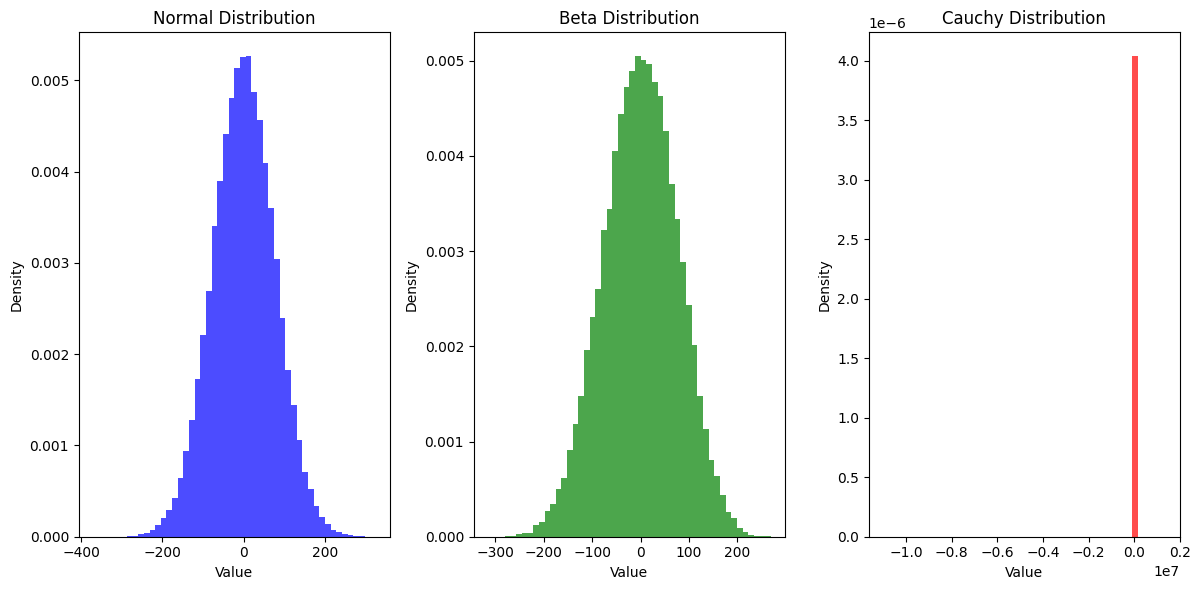

In [21]:
normal_mean, normal_std = 5.758677919705709e-12, 76.42310842343251

# Parameters for the beta distribution
beta_alpha, beta_beta, loc, scale = 16.41433438508734, 12.798375121527167, -475.7889575554446, 846.7624267268641

# Parameters for the Cauchy distribution
cauchy_loc, cauchy_scale = 1.2520209081838702, 46.10920442809238
# Set the seed for reproducibility
np.random.seed(0)

from scipy.stats import beta, cauchy
# Generate random samples from the normal distribution
normal_samples = np.random.normal(normal_mean, normal_std, 90000)

# Generate random samples from the beta distribution
beta_samples = beta.rvs(beta_alpha, beta_beta, loc=loc, scale=scale, size=90000)

# Generate random samples from the Cauchy distribution
cauchy_samples = cauchy.rvs(loc=cauchy_loc, scale=cauchy_scale, size=90000)

# Plot histograms of the random samples for each distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(normal_samples, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

plt.subplot(1, 3, 2)
plt.hist(beta_samples, bins=50, density=True, alpha=0.7, color='green')
plt.title('Beta Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

plt.subplot(1, 3, 3)
plt.hist(cauchy_samples, bins=50, density=True, alpha=0.7, color='red')
plt.title('Cauchy Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [22]:
one_std_dev_above = normal_mean + normal_std
one_std_dev_below = normal_mean - normal_std
two_std_dev_above = normal_mean + 2 * normal_std
two_std_dev_below = normal_mean - 2 * normal_std
print("1 Standard Deviation Above Mean:", one_std_dev_above)
print("1 Standard Deviation Below Mean:", one_std_dev_below)
print("2 Standard Deviations Above Mean:", two_std_dev_above)
print("2 Standard Deviations Below Mean:", two_std_dev_below)

1 Standard Deviation Above Mean: 76.42310842343826
1 Standard Deviation Below Mean: -76.42310842342675
2 Standard Deviations Above Mean: 152.8462168468708
2 Standard Deviations Below Mean: -152.84621684685925


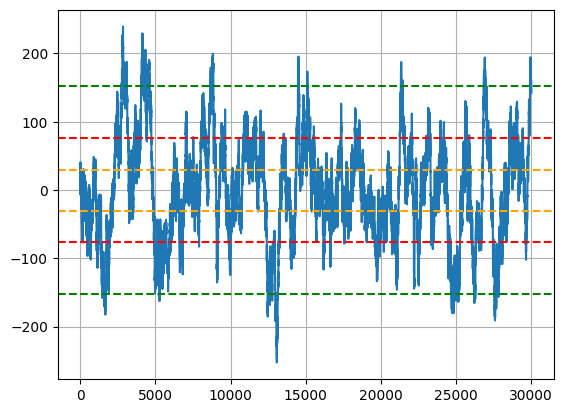

In [23]:
(trend - mean).plot(grid = True)
plt.axhline(one_std_dev_above, color='red', linestyle='--', label='1 Std Dev Above Mean')
plt.axhline(one_std_dev_below, color='red', linestyle='--', label='1 Std Dev Below Mean')
plt.axhline(two_std_dev_above, color='green', linestyle='--', label='2 Std Dev Above Mean')
plt.axhline(two_std_dev_below, color='green', linestyle='--', label='2 Std Dev Below Mean')

plt.axhline(30, color='orange', linestyle='--', label='2 Std Dev Below Mean')
plt.axhline(-30, color='orange', linestyle='--', label='2 Std Dev Below Mean')


In [24]:
d0 = df[df.day == 0]
d1 = df[df.day == 1]
d2 = df[df.day == 2]

<Axes: >

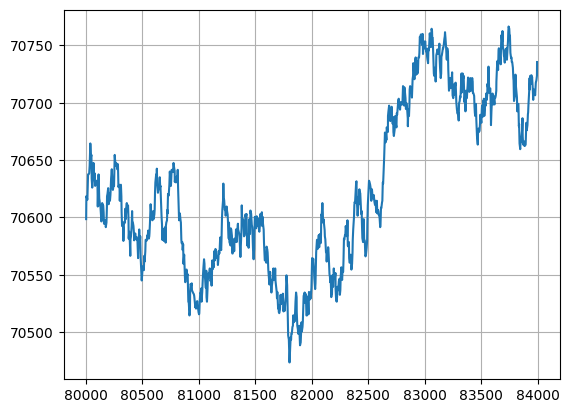

In [87]:
d2[(d2['product'] == 'GIFT_BASKET') & (d2.timestamp < 100000)].mid_price.plot(grid = True)

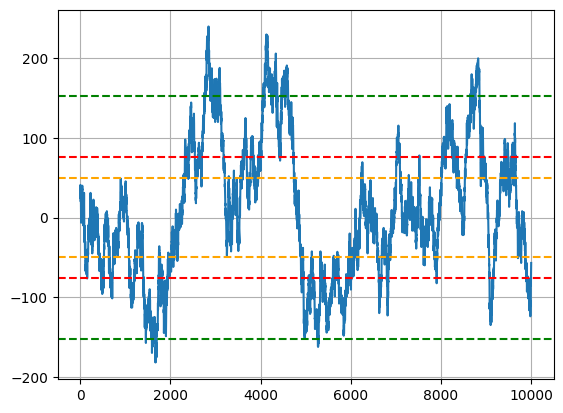

In [114]:
def plotter(df):
    choco = df[df['product'] == 'CHOCOLATE'].reset_index().drop(columns = 'index')
    straw = df[df['product'] == 'STRAWBERRIES'].reset_index().drop(columns = 'index')
    rose = df[df['product'] == 'ROSES'].reset_index().drop(columns = 'index')
    gift = df[df['product'] == 'GIFT_BASKET'].reset_index().drop(columns = 'index')

    trend = (choco.mid_price * 4 + straw.mid_price * 6 + rose.mid_price - gift.mid_price) + 380
    (trend).plot(grid = True)
    plt.axhline(one_std_dev_above, color='red', linestyle='--', label='1 Std Dev Above Mean')
    plt.axhline(one_std_dev_below, color='red', linestyle='--', label='1 Std Dev Below Mean')
    plt.axhline(two_std_dev_above, color='green', linestyle='--', label='2 Std Dev Above Mean')
    plt.axhline(two_std_dev_below, color='green', linestyle='--', label='2 Std Dev Below Mean')

    plt.axhline(50, color='orange', linestyle='--', label='2 Std Dev Below Mean')
    plt.axhline(-50, color='orange', linestyle='--', label='2 Std Dev Below Mean')
plotter(d0[d0.timestamp < 1000000])

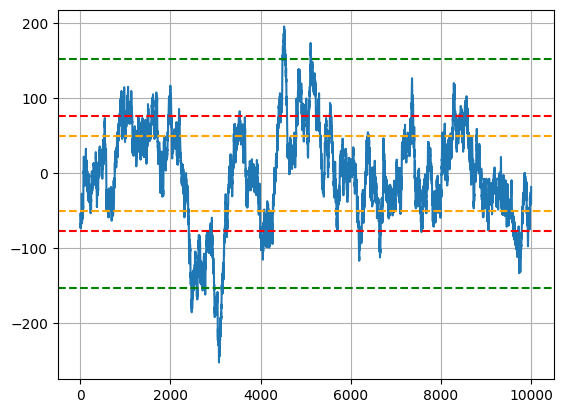

In [115]:
plotter(d1[d1.timestamp < 1000000])

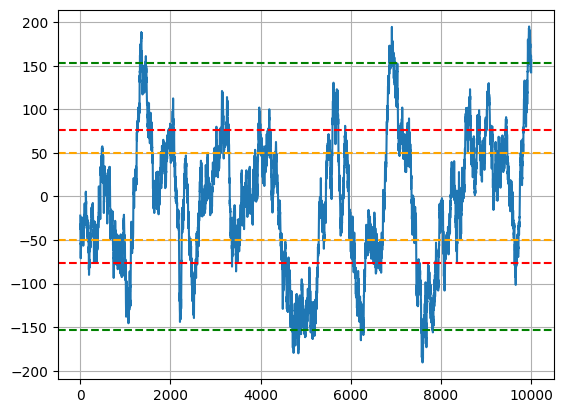

In [116]:
plotter(d2[d2.timestamp < 1000000])

MFPT for threshold -150: 185.69718309859155
MFPT for threshold -149: 193.88970588235293
MFPT for threshold -148: 174.67549668874173
MFPT for threshold -147: 157.94011976047904
MFPT for threshold -146: 139.55555555555554
MFPT for threshold -145: 129.2941176470588
MFPT for threshold -144: 127.42028985507247
MFPT for threshold -143: 125.6
MFPT for threshold -142: 128.67317073170733
MFPT for threshold -141: 119.36651583710407
MFPT for threshold -140: 109.46058091286307
MFPT for threshold -139: 104.28063241106719
MFPT for threshold -138: 106.0281124497992
MFPT for threshold -137: 104.76984126984127
MFPT for threshold -136: 107.76326530612245
MFPT for threshold -135: 101.55
MFPT for threshold -134: 100.01515151515152
MFPT for threshold -133: 104.78174603174604
MFPT for threshold -132: 105.62
MFPT for threshold -131: 103.14453125
MFPT for threshold -130: 100.79389312977099
MFPT for threshold -129: 100.41444866920152
MFPT for threshold -128: 97.81111111111112
MFPT for threshold -127: 96.383211

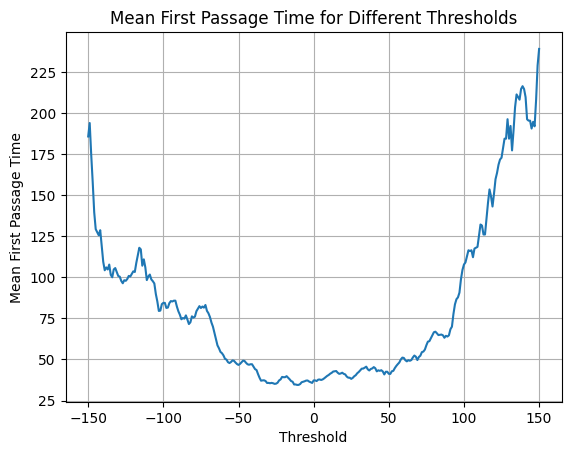

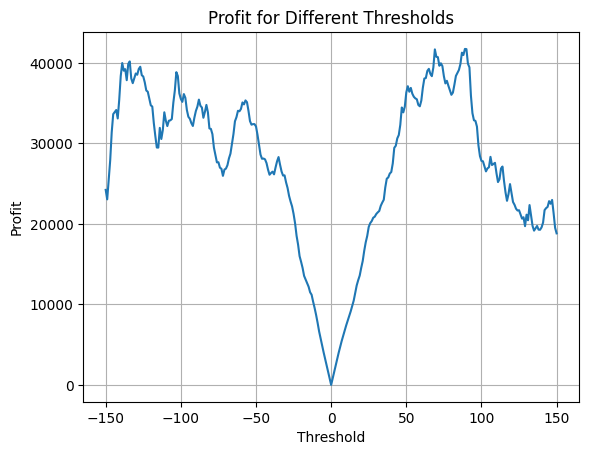

In [48]:
def calculate_mfpt(time_series, threshold):
    crossing_times = []
    current_value = None

    for i, value in enumerate(time_series):
        if current_value is None:
            current_value = value
            continue

        if (current_value <= threshold and value > threshold) or (current_value >= threshold and value < threshold):
            crossing_times.append(i)
        
        current_value = value

    if len(crossing_times) < 2:
        return None

    passage_times = [crossing_times[i + 1] - crossing_times[i] for i in range(len(crossing_times) - 1)]
    return sum(passage_times) / len(passage_times)

a = df
choco = a[a['product'] == 'CHOCOLATE'].reset_index().drop(columns = 'index')
straw = a[a['product'] == 'STRAWBERRIES'].reset_index().drop(columns = 'index')
rose = a[a['product'] == 'ROSES'].reset_index().drop(columns = 'index')
gift = a[a['product'] == 'GIFT_BASKET'].reset_index().drop(columns = 'index')

t = (choco.mid_price * 4 + straw.mid_price * 6 + rose.mid_price - gift.mid_price) + 380

time_series = t
thresholds = range(-150, 151, 1)
profits = []
mfpts = []

for threshold in thresholds:
    mfpt = calculate_mfpt(time_series, threshold)
    print(f"MFPT for threshold {threshold}: {mfpt}")
    mfpts.append(mfpt)
    profits.append((30000/mfpt) * abs(threshold))

# Plot MFPTs
plt.plot(thresholds, mfpts)
plt.xlabel('Threshold')
plt.ylabel('Mean First Passage Time')
plt.title('Mean First Passage Time for Different Thresholds')
plt.grid(True)
plt.show()

# Plot Profits
plt.plot(thresholds, profits)
plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.title('Profit for Different Thresholds')
plt.grid(True)
plt.show()

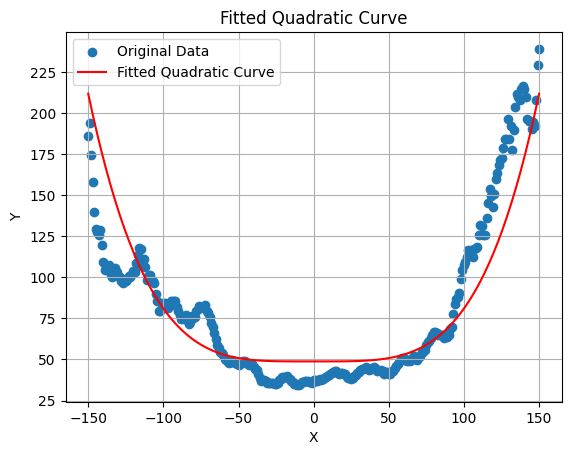

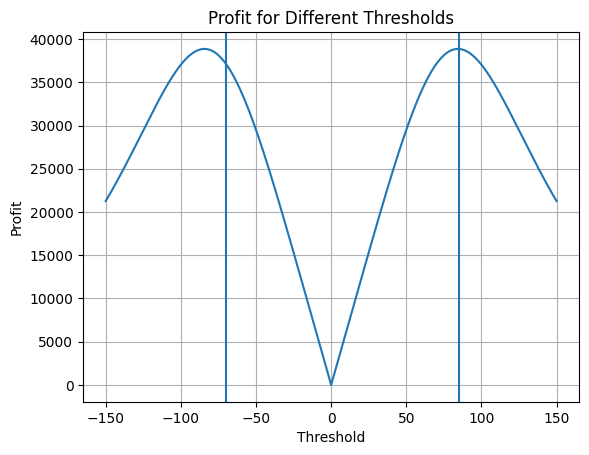

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def quadratic_func(x, a, b, c):
    return a * x**4 + 0 * x + c

x_data = [i for i in thresholds]
y_data = mfpts

popt, pcov = curve_fit(quadratic_func, x_data, y_data,)

a, b, c = popt

# Generate the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = quadratic_func(x_fit, a, b, c)

plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_fit, y_fit, color='red', label='Fitted Quadratic Curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitted Quadratic Curve')
plt.legend()
plt.grid(True)
plt.show()

th_profits = []
for i in thresholds:
    th_profits.append((30000/quadratic_func(i, a, b, c)) * abs(i))

plt.plot(thresholds, th_profits)
plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.title('Profit for Different Thresholds')
plt.grid(True)
plt.axvline(-70)
plt.axvline(85)
plt.show()


In [69]:
a,b,c # around 70 for 2, 

(3.217688142806719e-07, 1.0, 48.82929491381073)

In [75]:
d2

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,total_time
80000,2,0,ROSES,14421.0,27,14420.0,35,NaN,0,14422.0,62,NaN,0,NaN,0,14421.5,0.0,2000000
80001,2,0,STRAWBERRIES,4036.0,255,NaN,0,NaN,0,4037.0,255,NaN,0,NaN,0,4036.5,0.0,2000000
80002,2,0,CHOCOLATE,7888.0,123,NaN,0,NaN,0,7890.0,123,NaN,0,NaN,0,7889.0,0.0,2000000
80003,2,0,GIFT_BASKET,70593.0,1,70592.0,10,70591.0,27,70604.0,1,70605.0,10,70606.0,27,70598.5,0.0,2000000
80004,2,100,CHOCOLATE,7889.0,102,NaN,0,NaN,0,7890.0,48,7891.0,54,NaN,0,7889.5,0.0,2000100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,2,999800,GIFT_BASKET,69537.0,2,69536.0,18,69535.0,24,69547.0,2,69548.0,18,69550.0,24,69542.0,0.0,2999800
119996,2,999900,CHOCOLATE,7749.0,143,NaN,0,NaN,0,7751.0,143,NaN,0,NaN,0,7750.0,0.0,2999900
119997,2,999900,GIFT_BASKET,69551.0,1,69550.0,19,69549.0,20,69561.0,1,69562.0,19,69564.0,20,69556.0,0.0,2999900
119998,2,999900,STRAWBERRIES,3984.0,240,NaN,0,NaN,0,3985.0,92,3986.0,148,NaN,0,3984.5,0.0,2999900
